In [5]:
import pandas as pd
import numpy as np
import joblib

In [7]:
df = pd.read_csv('train.csv')

In [9]:
df.head()

,label,email
0,spam,attn i am bulawa mulete jr the son of mr steve...
1,ham,That depends. How would you like to be treated...
2,ham,"Wen u miss someone, the person is definitely s..."
3,spam,Win the newest “Harry Potter and the Order of ...
4,ham,Where are you lover ? I need you ...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5863 entries, 0 to 5862
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5844 non-null   object
 1   email   5844 non-null   object
dtypes: object(2)
memory usage: 91.7+ KB


In [13]:
#смотрим все labels и понимаем что есть какой-то ошибочный
unique_labels = df['label'].unique()
print(unique_labels)

['spam' 'ham' nan '{"mode":"full"']


In [15]:
#смотрим общее количество каждого лэйбла и понимаем что у нас будет несбалансированные выборка
label_counts = df['label'].value_counts()
print(label_counts)

label
ham               4944
spam               899
{"mode":"full"       1
Name: count, dtype: int64


In [17]:
#смотрим на строки с пропусками и в следующем чанке удаляем их
nan_counts = df.isnull().sum()
print(nan_counts)

label    19
email    19
dtype: int64


In [19]:
df = df.dropna()

In [21]:
#удаляем все лэйблы кроме ham и spam
df = df[df['label'].isin(['ham', 'spam'])]

In [23]:
#загружаем тестовую выбоку и делаем все тоже самое что и с тренеровочной
df_test = pd.read_csv('test.csv')

In [25]:
label_counts = df_test['label'].value_counts()
print(label_counts)

label
ham     2467
spam     422
Name: count, dtype: int64


In [27]:
unique_labels = df_test['label'].unique()
print(unique_labels)

['ham' 'spam']


In [29]:
nan_counts = df_test.isnull().sum()
print(nan_counts)

label    0
email    0
dtype: int64


In [31]:
#переводим лэйблы в числовой формат где spam 1 а ham 0
df['label'] = df['label'].replace({'spam': 1.0, 'ham': 0.0}).astype(float)
df_test['label'] = df_test['label'].replace({'spam': 1.0, 'ham': 0.0}).astype(float)

In [33]:
df.head

<bound method NDFrame.head of       label                                              email
0       1.0  attn i am bulawa mulete jr the son of mr steve...
1       0.0  That depends. How would you like to be treated...
2       0.0  Wen u miss someone, the person is definitely s...
3       1.0  Win the newest “Harry Potter and the Order of ...
4       0.0               Where are you lover ? I need you ...
...     ...                                                ...
5858    0.0  Eek that's a lot of time especially since Amer...
5859    0.0  Aight I'll grab something to eat too, text me ...
5860    0.0                       I havent lei.. Next mon can?
5861    0.0  Ok but tell me half an hr b4 u come i need 2 p...
5862    0.0  on wed NUMBER NUMBER NUMBER at NUMBER NUMBER g...

[5824 rows x 2 columns]>

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5824 entries, 0 to 5862
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   5824 non-null   float64
 1   email   5824 non-null   object 
dtypes: float64(1), object(1)
memory usage: 136.5+ KB


In [39]:
# загружаем bert для превращения текста в эмбеденги
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

D:\test\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
#переделываем текст в эмбеденги
from tqdm import tqdm  

def extract_features(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Используем представление [CLS] токена
    return outputs.last_hidden_state[0][0].numpy()

features = np.array([extract_features(text) for text in tqdm(df['email'], desc="Обработка email")])
features_test = np.array([extract_features(text) for text in tqdm(df_test['email'], desc="Обработка тестовых email")])

Обработка тестовых email: 100%|████████████████████████████████████████████████████| 2889/2889 [05:20<00:00,  9.01it/s]


In [43]:
features.shape

(5824, 768)

In [45]:
#сохраним на всякий случай
import h5py
import numpy as np

with h5py.File('data.h5', 'w') as f:
    f.create_dataset('features', data=features)
    f.create_dataset('label', data=df['label'])
    
with h5py.File('data_test.h5', 'w') as f:
    f.create_dataset('features', data=features_test)
    f.create_dataset('label', data=df_test['label'])

In [47]:
#формируем тренеровочные и тестовые данные
X_train = features
y_train = df['label']
X_test = features_test
y_test  = df_test['label']

In [51]:
#обучим логрегрессию
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

D:\test\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
#смотрим на метрики(на Accuracy не сильно обращаем внимание тк выборки не сбалансированные) смотрим на F1 и видим что она получилось тоже очень высокой
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.98
Precision: 0.97
Recall: 0.93
F1 Score: 0.95


In [55]:
# cохраним на всякий случай логрегрессию
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [57]:
#обучим случайный лес
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=100, random_state=42)

model_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
#получилось так что recoll низковатой это плохо если нам важно
#минимизировать количество пропущенных спам-сообщений. Это критично, если пропуск спама может иметь серьезные последствия.
#можно просто лучше настроить случайный лес и тогда получиться улучшить результат
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred = model_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.96
Precision: 0.98
Recall: 0.76
F1 Score: 0.86


In [61]:
joblib.dump(model_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [65]:
#обучим градиентный бустинг
from xgboost import XGBClassifier

model_gradboosting = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model_gradboosting.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
#тут такая же ситуация, что и со случайным лесом, но лучше. Чтобы улучшить результат надо более тонко настроить модель
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred = model_gradboosting.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.97
Precision: 0.96
Recall: 0.86
F1 Score: 0.90


In [69]:
joblib.dump(model_gradboosting, 'XGBClassifier.pkl')

['XGBClassifier.pkl']

In [71]:
#решил обучить линейный перцептрон. Тут представлена архитектура  
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset

class MyNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyNN, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 2 * input_dim)  # Первый скрытый слой, в 2 раза больше входного
        self.relu = nn.ReLU()
        
        self.layer_2 = nn.Linear(2 * input_dim, input_dim)  # Второй скрытый слой, размер 768
        
        self.layer_3 = nn.Linear(input_dim, output_dim, bias=False)  # Последний слой без смещения

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        
        return x

model = MyNN(768, 1)

In [73]:
#класс для датасета
class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.float)
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [75]:
dataset = TextEmbeddingDataset(X_train, y_train)

In [77]:
#тк выборка не сбалансированная будем использовать кросс валидацию на 5 фолдлов 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [79]:
#определяем функцию потерь и оптимизатор
loss_model = nn.BCEWithLogitsLoss()
opt=torch.optim.Adam(model.parameters(),lr=0.001)

In [81]:
EPOCHS = 10
threshold = 0.5

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}/{skf.n_splits}")
    
    # Создаем DataLoader для текущей эпохи
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)
    #проход по тренеровочным данным и подсчет метрик
    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = []
        true_answer = 0
        train_loop = tqdm(train_loader, leave=False)
        for x, targets in train_loop:
            x, targets = x.to(dtype=torch.float32), targets.to(dtype=torch.float32)
            pred = model(x)
            loss = loss_model(pred.squeeze(), targets) 
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss) / len(running_train_loss)
            train_loop.set_description(f"Epoch[{epoch+1}/{EPOCHS}]")
            
            pred_class = torch.sigmoid(pred).round()
            true_answer += (pred_class.squeeze() == targets).sum().item()

        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        running_train_acc = true_answer / len(train_subset)
        train_loss.append(mean_train_loss)
        train_acc.append(running_train_acc)
        
        model.eval()
        # проход по валидационным данным и подсчет метрик
        with torch.no_grad():
            running_val_loss = []
            true_answer = 0
            
            for x, targets in val_loader:
                x, targets = x.to(dtype=torch.float32), targets.to(dtype=torch.float32)
                pred = model(x)
                loss = loss_model(pred.squeeze(), targets)
                running_val_loss.append(loss.item())
                
                pred_class = torch.sigmoid(pred).round()
                true_answer += (pred_class.squeeze() == targets).sum().item()

            mean_val_loss = sum(running_val_loss) / len(running_val_loss)
            running_val_acc = true_answer / len(val_subset)
            val_loss.append(mean_val_loss)
            val_acc.append(running_val_acc)

        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler._last_lr[0]
        print(f"Epoch[{epoch+1}/{EPOCHS}] train_loss={mean_train_loss:.4f} train_acc={running_train_acc:.4f} val_loss={mean_val_loss:.4f} val_acc={running_val_acc:.4f} lr={lr:.4f}")


Fold 1/5


Epoch[1/10] train_loss=0.1598 train_acc=0.9386 val_loss=0.0792 val_acc=0.9760 lr=0.0010


Epoch[2/10] train_loss=0.0642 train_acc=0.9794 val_loss=0.0641 val_acc=0.9794 lr=0.0010


Epoch[3/10] train_loss=0.0530 train_acc=0.9835 val_loss=0.0538 val_acc=0.9837 lr=0.0010


Epoch[4/10] train_loss=0.0444 train_acc=0.9863 val_loss=0.0586 val_acc=0.9803 lr=0.0010


Epoch[5/10] train_loss=0.0317 train_acc=0.9912 val_loss=0.0608 val_acc=0.9828 lr=0.0010


Epoch[6/10] train_loss=0.0320 train_acc=0.9906 val_loss=0.0472 val_acc=0.9828 lr=0.0010


Epoch[7/10] train_loss=0.0256 train_acc=0.9927 val_loss=0.0607 val_acc=0.9854 lr=0.0010


Epoch[8/10] train_loss=0.0209 train_acc=0.9933 val_loss=0.0718 val_acc=0.9785 lr=0.0010


Epoch[9/10] train_loss=0.0291 train_acc=0.9899 val_loss=0.0708 val_acc=0.9845 lr=0.0010


Epoch[10/10] train_loss=0.0193 train_acc=0.9923 val_loss=0.0608 val_acc=0.9863 lr=0.0010
Fold 2/5


Epoch[1/10] train_loss=0.0295 train_acc=0.9908 val_loss=0.0136 val_acc=0.9957 lr=0.0010


Epoch[2/10] train_loss=0.0229 train_acc=0.9936 val_loss=0.0147 val_acc=0.9974 lr=0.0010


Epoch[3/10] train_loss=0.0185 train_acc=0.9938 val_loss=0.0191 val_acc=0.9940 lr=0.0010


Epoch[4/10] train_loss=0.0125 train_acc=0.9957 val_loss=0.0242 val_acc=0.9906 lr=0.0010


Epoch[5/10] train_loss=0.0127 train_acc=0.9948 val_loss=0.0406 val_acc=0.9888 lr=0.0010


Epoch[6/10] train_loss=0.0113 train_acc=0.9957 val_loss=0.0292 val_acc=0.9931 lr=0.0010


Epoch[7/10] train_loss=0.0107 train_acc=0.9951 val_loss=0.0280 val_acc=0.9914 lr=0.0010


Epoch[8/10] train_loss=0.0082 train_acc=0.9968 val_loss=0.0273 val_acc=0.9931 lr=0.0010


Epoch[9/10] train_loss=0.0106 train_acc=0.9948 val_loss=0.0293 val_acc=0.9940 lr=0.0010


Epoch[10/10] train_loss=0.0037 train_acc=0.9985 val_loss=0.0284 val_acc=0.9931 lr=0.0010
Fold 3/5


Epoch[1/10] train_loss=0.0172 train_acc=0.9946 val_loss=0.0109 val_acc=0.9966 lr=0.0010


Epoch[2/10] train_loss=0.0063 train_acc=0.9987 val_loss=0.0057 val_acc=0.9983 lr=0.0010


Epoch[3/10] train_loss=0.0031 train_acc=0.9991 val_loss=0.0054 val_acc=0.9983 lr=0.0010


Epoch[4/10] train_loss=0.0035 train_acc=0.9994 val_loss=0.0074 val_acc=0.9983 lr=0.0010


Epoch[5/10] train_loss=0.0019 train_acc=0.9989 val_loss=0.0095 val_acc=0.9966 lr=0.0010


Epoch[6/10] train_loss=0.0017 train_acc=0.9996 val_loss=0.0075 val_acc=0.9974 lr=0.0010


Epoch[7/10] train_loss=0.0022 train_acc=0.9994 val_loss=0.0104 val_acc=0.9974 lr=0.0010


Epoch[8/10] train_loss=0.0014 train_acc=0.9996 val_loss=0.0087 val_acc=0.9974 lr=0.0010


Epoch[9/10] train_loss=0.0013 train_acc=0.9994 val_loss=0.0113 val_acc=0.9966 lr=0.0010


Epoch[10/10] train_loss=0.0025 train_acc=0.9991 val_loss=0.0114 val_acc=0.9974 lr=0.0010
Fold 4/5


Epoch[1/10] train_loss=0.0097 train_acc=0.9968 val_loss=0.0372 val_acc=0.9803 lr=0.0010


Epoch[2/10] train_loss=0.0239 train_acc=0.9903 val_loss=0.0054 val_acc=0.9974 lr=0.0010


Epoch[3/10] train_loss=0.0125 train_acc=0.9957 val_loss=0.0270 val_acc=0.9863 lr=0.0010


Epoch[4/10] train_loss=0.0063 train_acc=0.9976 val_loss=0.0108 val_acc=0.9966 lr=0.0010


Epoch[5/10] train_loss=0.0050 train_acc=0.9976 val_loss=0.0130 val_acc=0.9948 lr=0.0010


Epoch[6/10] train_loss=0.0046 train_acc=0.9983 val_loss=0.0372 val_acc=0.9880 lr=0.0010


Epoch[7/10] train_loss=0.0039 train_acc=0.9989 val_loss=0.0156 val_acc=0.9957 lr=0.0010


Epoch[8/10] train_loss=0.0022 train_acc=0.9991 val_loss=0.0169 val_acc=0.9948 lr=0.0010


Epoch[9/10] train_loss=0.0014 train_acc=0.9994 val_loss=0.0164 val_acc=0.9948 lr=0.0010


Epoch[10/10] train_loss=0.0008 train_acc=0.9998 val_loss=0.0205 val_acc=0.9957 lr=0.0010
Fold 5/5


Epoch[1/10] train_loss=0.0067 train_acc=0.9979 val_loss=0.0006 val_acc=1.0000 lr=0.0010


Epoch[2/10] train_loss=0.0070 train_acc=0.9979 val_loss=0.0034 val_acc=0.9991 lr=0.0010


Epoch[3/10] train_loss=0.0119 train_acc=0.9961 val_loss=0.0038 val_acc=0.9991 lr=0.0010


Epoch[4/10] train_loss=0.0140 train_acc=0.9946 val_loss=0.0408 val_acc=0.9802 lr=0.0010


Epoch[5/10] train_loss=0.0138 train_acc=0.9957 val_loss=0.0013 val_acc=0.9991 lr=0.0010


Epoch[6/10] train_loss=0.0023 train_acc=0.9991 val_loss=0.0008 val_acc=1.0000 lr=0.0010


Epoch[7/10] train_loss=0.0013 train_acc=0.9991 val_loss=0.0007 val_acc=1.0000 lr=0.0010


Epoch[8/10] train_loss=0.0011 train_acc=0.9987 val_loss=0.0006 val_acc=1.0000 lr=0.0010


Epoch[9/10] train_loss=0.0011 train_acc=0.9991 val_loss=0.0006 val_acc=1.0000 lr=0.0010


Epoch[10/10] train_loss=0.0010 train_acc=0.9994 val_loss=0.0007 val_acc=0.9991 lr=0.0010


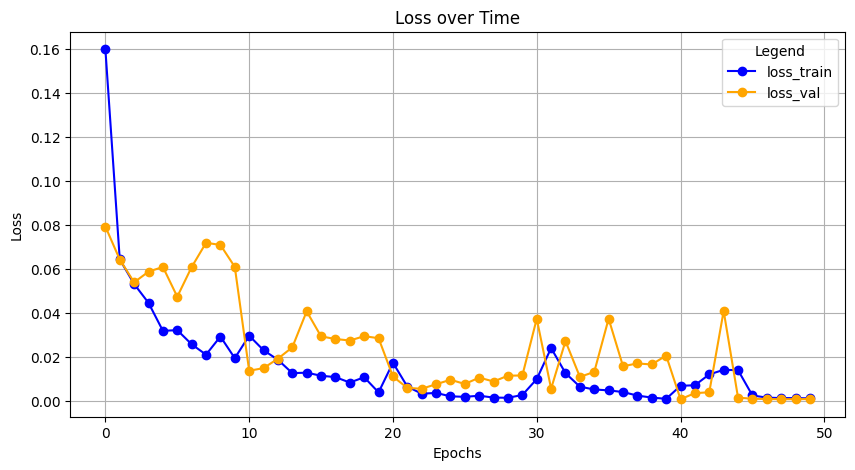

In [95]:
#смотрим на графики чтобы не было расхождения(переобучения)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(train_loss, label='loss_train', color='blue', linestyle='-', marker='o')
plt.plot(val_loss, label='loss_val', color='orange', linestyle='-', marker='o')

plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(title='Legend')
plt.grid()

# Показать график
plt.show()

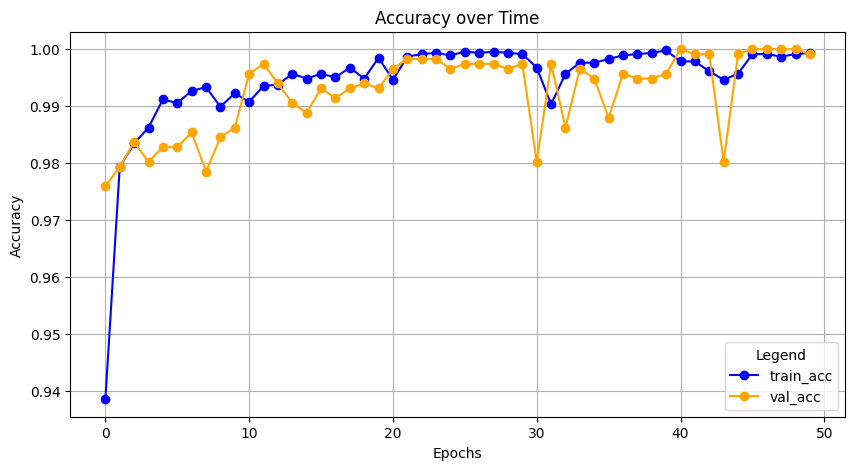

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(train_acc, label='train_acc', color='blue', linestyle='-', marker='o')
plt.plot(val_acc, label='val_acc', color='orange', linestyle='-', marker='o')

plt.title('Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Legend')
plt.grid()

plt.show()

In [99]:
test_data = TextEmbeddingDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=256,shuffle=False)

In [101]:
#тут мы получили самые высокие метрики
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval() 
    with torch.no_grad():
        for batch_embeddings, batch_labels in dataloader:
            outputs = model(batch_embeddings)
            preds = torch.sigmoid(outputs).squeeze().numpy()  
            all_preds.extend(preds)
            all_labels.extend(batch_labels.numpy())
    
    return all_preds, all_labels

preds, true_labels = evaluate_model(model, test_loader)

# Преобразование предсказаний в бинарный формат
preds = [1 if p > 0.5 else 0 for p in preds] 

accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds)
recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9893
Precision: 0.9711
Recall: 0.9550
F1 Score: 0.9630


In [103]:
# Сохранение всей модели (включая архитектуру)
torch.save(model, 'model.pth')